In [1]:
import sklearn
import xgboost as xgb
import catboost
import lightgbm
import tsfresh
from sklearn.model_selection import train_test_split
import numpy as np


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
import pandas as pd

In [3]:
from matplotlib import pyplot as plt

In [4]:
df = pd.read_csv('train_small.csv',header = None, index_col=0)
dt = pd.read_csv('test_small.csv', index_col=0)

newcolnames = ["var_{}".format(i) for i in range(200)]
newcolnames.insert(0,"target")

df.columns = newcolnames

In [5]:
X0 = df[ df["target"] == 0]
X1 = df[ df["target"] == 1]
X = df.drop("target", 1)
y = df["target"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
d_train = xgb.DMatrix(X_train, label = y_train, missing = -1)
d_test = xgb.DMatrix(X_test)

train_labels = d_train.get_label()
ratio = float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)

params = {
    'objective': 'binary:logistic',
    'silent': 1,
    'eta': 0.3,
    'max_depth': 1,
    'scale_pos_weight': ratio,
    'subsample': 0.8,
    'learning_rate': 0.3,
    'colsample_bytree': 0.5,
    'gamma': 1
}
num_round = 81

/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


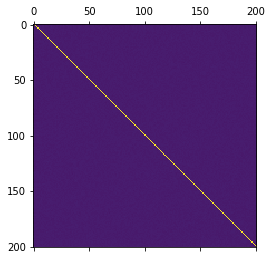

In [8]:
plt.matshow(df.corr())
plt.show()

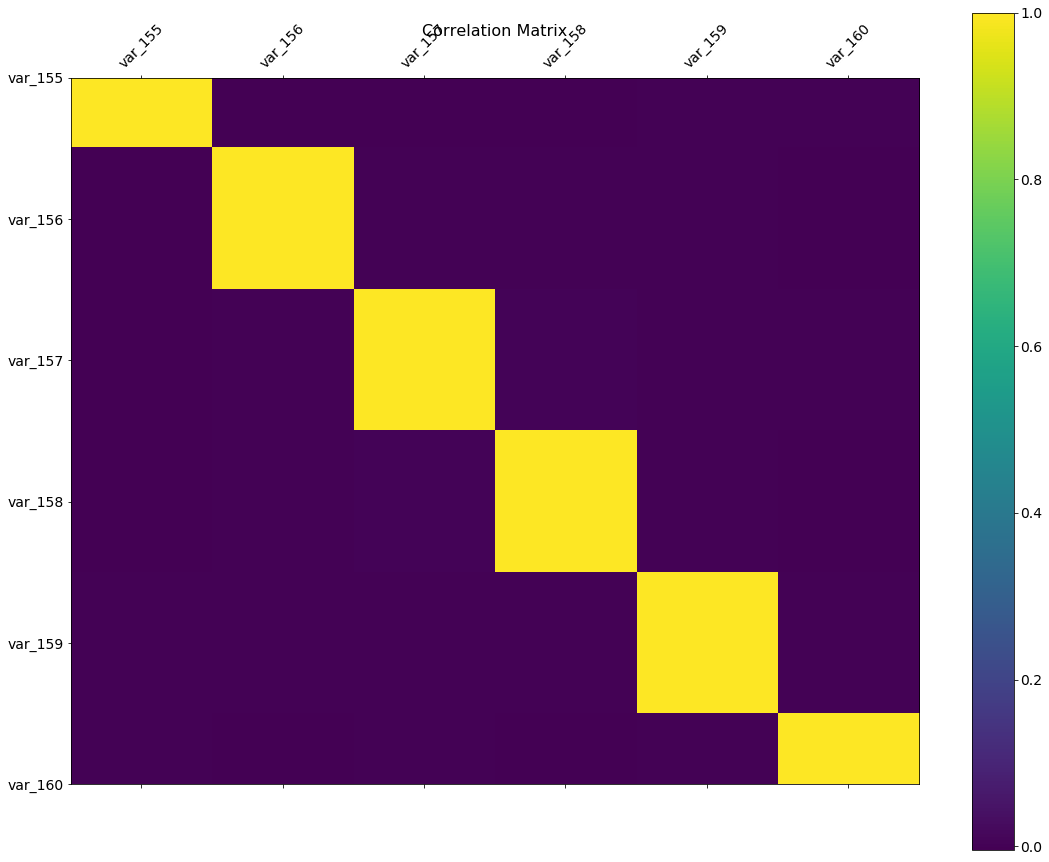

In [9]:

df2 = df[['var_155','var_156','var_157','var_158','var_159','var_160']]
f = plt.figure(figsize=(19, 15))
plt.matshow(df2.corr(), fignum=f.number)
plt.xticks(range(df2.shape[1]), df2.columns, fontsize=14, rotation=45)
plt.yticks(range(df2.shape[1]), df2.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

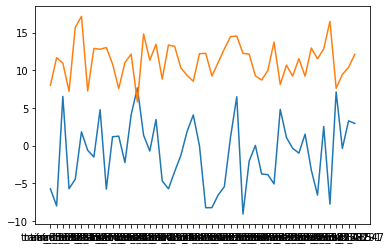

In [10]:
df2 = (df[['var_1', 'var_2']])
plt.plot(df2.sample(50))

In [11]:
X_train

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,,,,,,,,,,,,,,,,,,,,,
train_111155,6.5247,7.9569,9.8341,5.4769,13.1969,0.7479,7.0642,24.1624,4.5334,5.4751,...,3.4682,6.0500,1.4785,1.8883,14.6668,2.4364,7.7401,9.8439,11.6106,15.3233
train_136055,11.2880,-4.4541,8.2504,7.9795,11.4818,-4.2115,6.3380,13.9843,1.3377,8.0878,...,12.1441,5.8297,-0.1088,8.4508,21.6554,-0.7662,10.0745,9.3562,13.6290,6.3671
train_185712,4.0556,-4.1843,7.2613,6.5552,9.1894,-2.4679,5.5870,13.7759,3.5968,5.8923,...,1.4580,3.4931,0.6190,7.7664,19.6280,-0.6931,5.6613,6.7472,15.7576,0.0317
train_148659,6.1887,-1.4939,9.0494,6.5100,11.6331,6.9117,5.3932,19.9479,-4.9249,6.8176,...,-0.5128,7.4499,3.4506,1.4093,22.6459,2.4819,3.2510,8.4614,13.3045,-23.9079
train_97215,5.0354,2.8806,12.5168,6.3705,10.3363,-3.9769,5.8220,18.7491,-1.1112,6.1472,...,-0.8697,8.8317,3.4943,7.7125,22.0084,-2.4452,1.7772,7.0632,14.4699,-12.7253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
train_105972,9.9394,1.9835,16.7339,5.0538,10.8360,5.7763,5.3845,17.7477,1.5201,7.9158,...,2.1736,5.7689,1.6037,10.7905,14.8709,-1.7217,-0.6573,8.4244,17.7167,-19.7536
train_17899,12.4509,6.3178,8.1089,2.0499,8.2237,2.3583,5.7306,21.3121,5.2296,9.8236,...,-1.8114,11.9800,1.9670,2.6813,19.9578,-0.0809,1.3857,8.4455,14.9601,-19.2991
train_156537,6.8433,-0.9474,7.4351,5.9121,11.0796,-4.9989,4.3376,15.0502,1.1889,6.0734,...,0.1057,8.6156,2.2365,-3.0703,11.5964,-2.9275,6.1535,9.1510,13.7852,-8.5127


In [12]:
dt

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
ID_code,,,,,,,,,,,,,,,,,,,,,
train_0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
train_3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
train_7,13.5580,-7.9881,13.8776,7.5985,8.6543,0.8310,5.6890,22.3262,5.0647,7.1971,...,13.1700,6.5491,3.9906,5.8061,23.1407,-0.3776,4.2178,9.4237,8.6624,3.4806
train_12,8.7671,-4.6154,9.7242,7.4242,9.0254,1.4247,6.2815,12.3143,5.6964,6.0197,...,0.3782,7.4382,0.0854,1.3444,17.2439,-0.0798,5.7389,8.4897,17.0938,4.6106
train_14,13.8080,5.0514,17.2611,8.5120,12.8517,-9.1622,5.7327,21.0517,-4.5117,6.8116,...,1.0740,8.3220,3.2619,1.6738,17.4797,-0.0257,-3.5323,9.3439,24.4479,-5.1110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
train_199973,8.7758,-0.4604,8.0874,6.4538,13.0035,0.1872,4.3495,20.0410,3.8901,7.6730,...,4.5471,6.8276,2.5206,9.2046,19.5153,-1.2611,7.6877,8.2211,16.1504,22.6103
train_199978,12.2015,-0.8787,16.8069,9.1073,10.3219,7.0208,6.2587,19.8344,4.9897,7.6663,...,-0.8481,5.5487,2.0673,-5.6931,16.5850,-1.9920,3.1963,7.5484,13.1150,6.7866
train_199979,10.8208,-2.9344,15.0906,9.7810,9.4014,-4.5704,5.3201,16.0858,2.1450,5.5635,...,5.4512,10.1153,0.1237,3.1777,20.9673,-1.5221,6.5048,9.5072,17.3854,-4.0844


In [13]:
Yt

NameError: name 'Yt' is not defined

In [ ]:
X1

In [ ]:
X1

In [ ]:
X0